In [2]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb

import plotly.io as pio
import plotly.offline as py
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.svm import SVC

# Assuming you have the following imports for Plotly
import plotly.express as px
import plotly.graph_objects as go

# You can choose one of the following to set the default template for Plotly
pio.templates.default = "plotly"  # or any other template name you prefer

# Set Seaborn style if needed
sns.set(style="whitegrid")  # Choose the style that fits your preference

# Set up Plotly notebook mode
py.init_notebook_mode(connected=True)

# Print the list of files in the input directory
print(os.listdir("."))

import seaborn as sns
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

['1_🏡_Homepage.py', 'DatasetCleaning.ipynb', 'experience-at-titanic-pigeon-forge.jpg', 'gender_submission.csv', 'pages', 'test.csv', 'tested.csv', 'train.csv']


In [3]:
train_data = pd.read_csv("train.csv")
df_train = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# Print train and test columns
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
print('Train columns:', train.columns.tolist())
print('Test columns:', test.columns.tolist())

Train columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Test columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [6]:
#This is test file from titanic and gender_submission combined
tested = pd.read_csv("tested.csv")
tested.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
PassengerId = test['PassengerId']
train['Ticket_type'] = train['Ticket'].apply(lambda x: x[0:3])
train['Ticket_type'] = train['Ticket_type'].astype('category')
train['Ticket_type'] = train['Ticket_type'].cat.codes

test['Ticket_type'] = test['Ticket'].apply(lambda x: x[0:3])
test['Ticket_type'] = test['Ticket_type'].astype('category')
test['Ticket_type'] = test['Ticket_type'].cat.codes

In [8]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values 

In [11]:
import re

def get_title(name):
    title_search = re.search(r' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

full_data = [train_data, test_data]

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

    # Group all non-common titles into one single grouping "Rare"
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


Gender

In [ ]:
gender_data = pd.read_csv("gender_submission.csv")
gender_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
gender = pd.read_csv("gender_submission.csv")
print('Gender columns:', gender.columns.tolist())

Gender columns: ['PassengerId', 'Survived']


In [ ]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [ ]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


Age

In [ ]:
data = [train_data, test_data]
for dataset in data:
    mean = train_data["Age"].mean()
    std = test_data["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_data["Age"].astype(int)

C:\Users\bayan\AppData\Local\Temp\ipykernel_7772\3446187101.py:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\bayan\AppData\Local\Temp\ipykernel_7772\3446187101.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\bayan\AppData\Local\Temp\ipykernel_7772\3446187101.py:10: UserWarning:



`distplot` is a

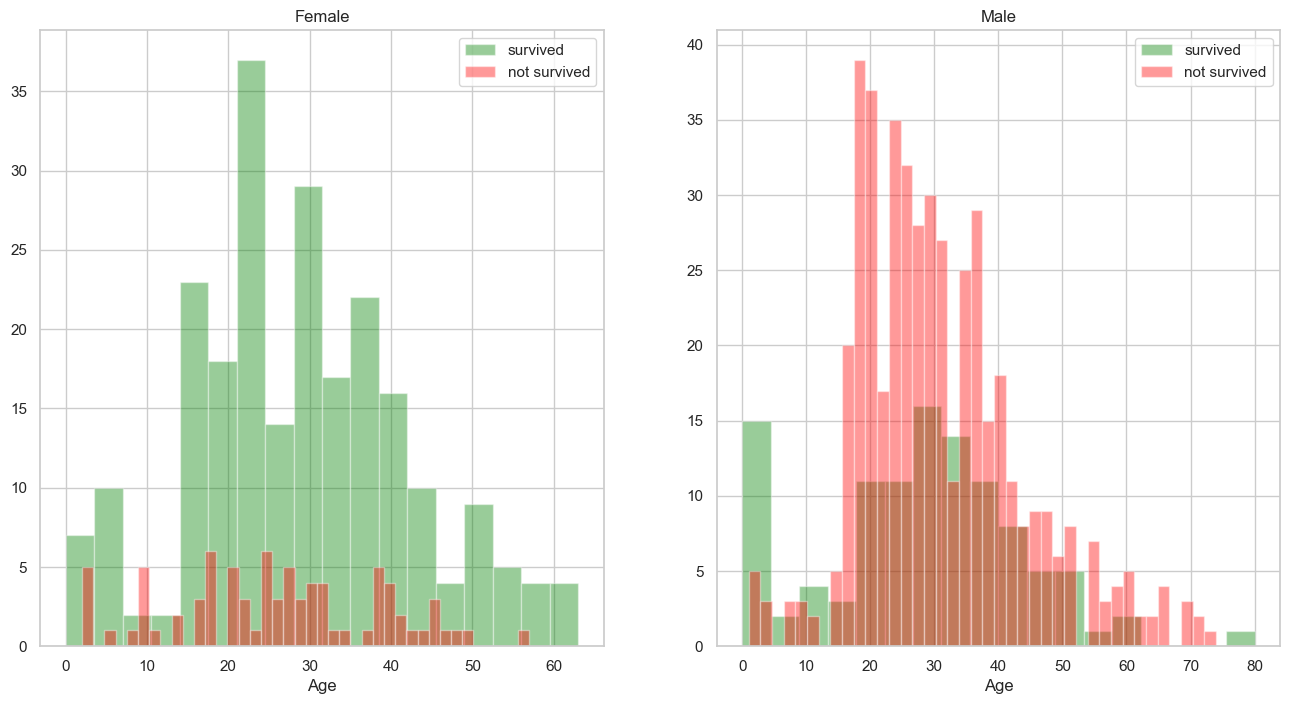

In [ ]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
women = train_data[train_data['Sex']=='female']
men = train_data[train_data['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False, color="green")
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False, color="red")
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False, color="green")
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color="red")
ax.legend()
_ = ax.set_title('Male');

In [ ]:
import pandas as pd
import plotly.express as px

df = pd.read_csv('train.csv')
fig = px.scatter_3d(df, x='PassengerId', y='Sex', z='Age', color='Age')
fig.show()

In [ ]:
df = pd.read_csv('tested.csv')

for template in ["plotly"]:
    fig = px.scatter(df,
                     x="PassengerId", y="Age", color="Survived",
                     log_x=True, size_max=20,
                     template=template, title="Which Age Survived?")
    fig.show()

Class

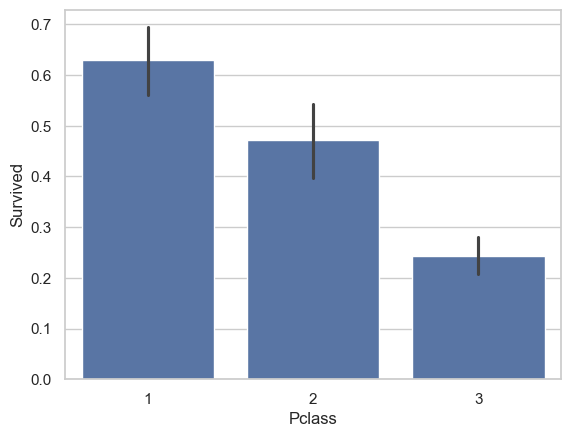

In [12]:
import seaborn as sns
import pandas as pd

# Assuming train_data is loaded from a CSV file or another source
train_data = pd.read_csv('train.csv')

sns.barplot(x='Pclass', y='Survived', data=train_data);

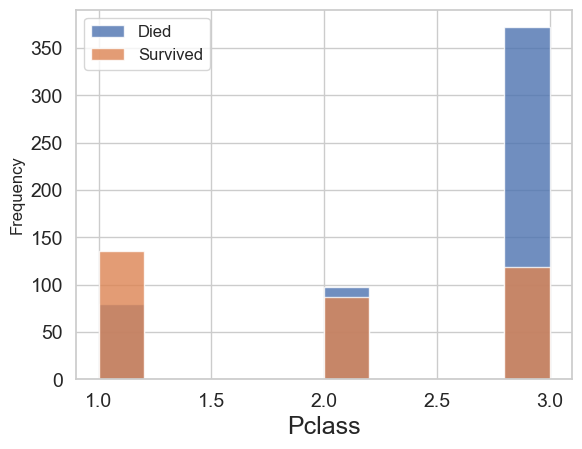

In [13]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

plt.figure()
fig = df_train.groupby('Survived')['Pclass'].plot.hist(histtype= 'bar', alpha = 0.8)
plt.legend(('Died','Survived'), fontsize = 12)
plt.xlabel('Pclass', fontsize = 18)
plt.show()

Embark

In [14]:
embarked_mode = train_data['Embarked'].mode()
data = [train_data, test_data]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(embarked_mode)

c:\Users\bayan\miniconda3\miniconda3.pt.2\envs\myenv\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.


c:\Users\bayan\miniconda3\miniconda3.pt.2\envs\myenv\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.


c:\Users\bayan\miniconda3\miniconda3.pt.2\envs\myenv\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.




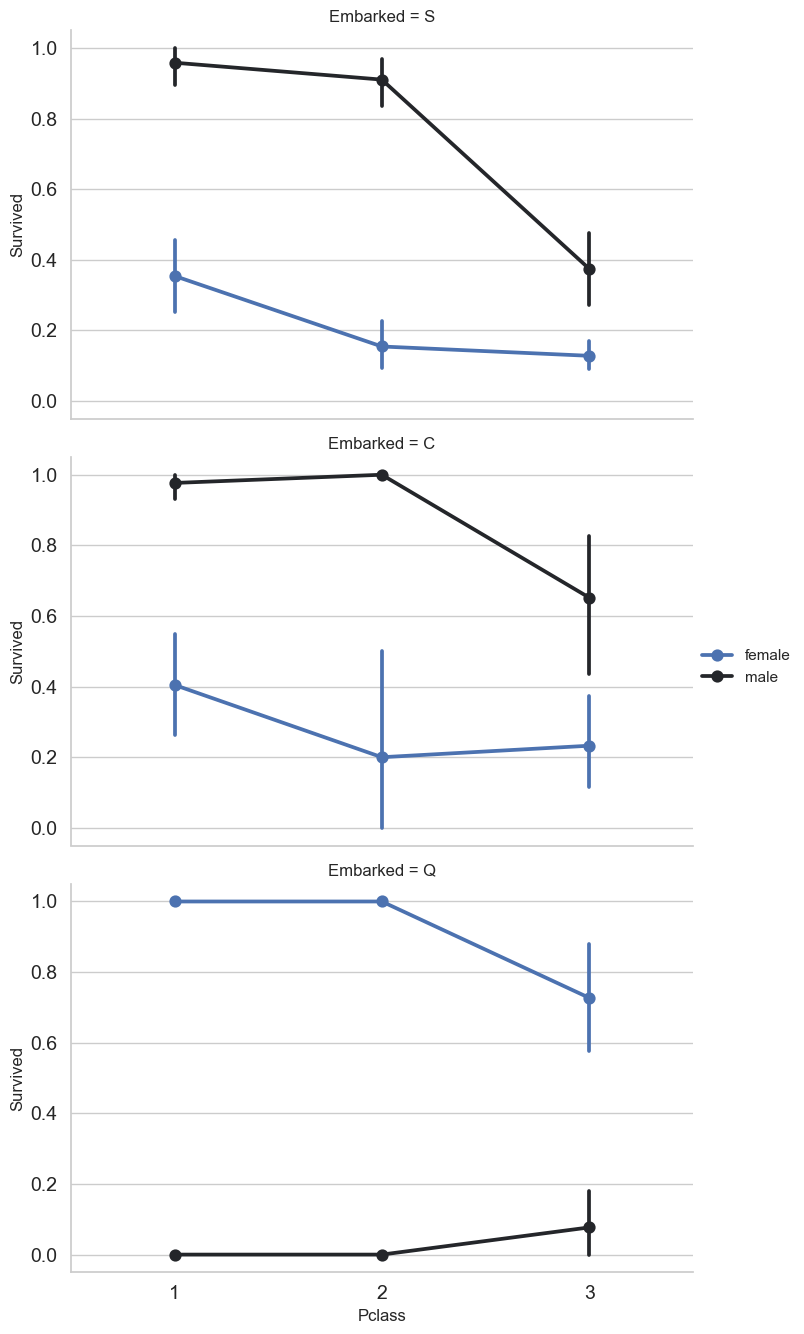

In [16]:
FacetGrid = sns.FacetGrid(train_data, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None)
FacetGrid.add_legend();

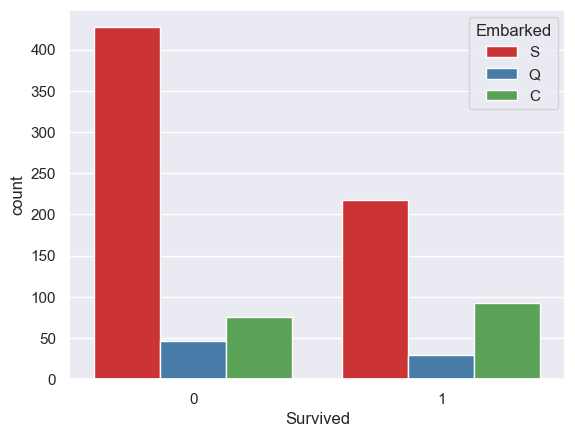

In [17]:
sns.set(style="darkgrid")
sns.countplot( x='Survived', data=train_data, hue="Embarked", palette="Set1");

Relatives

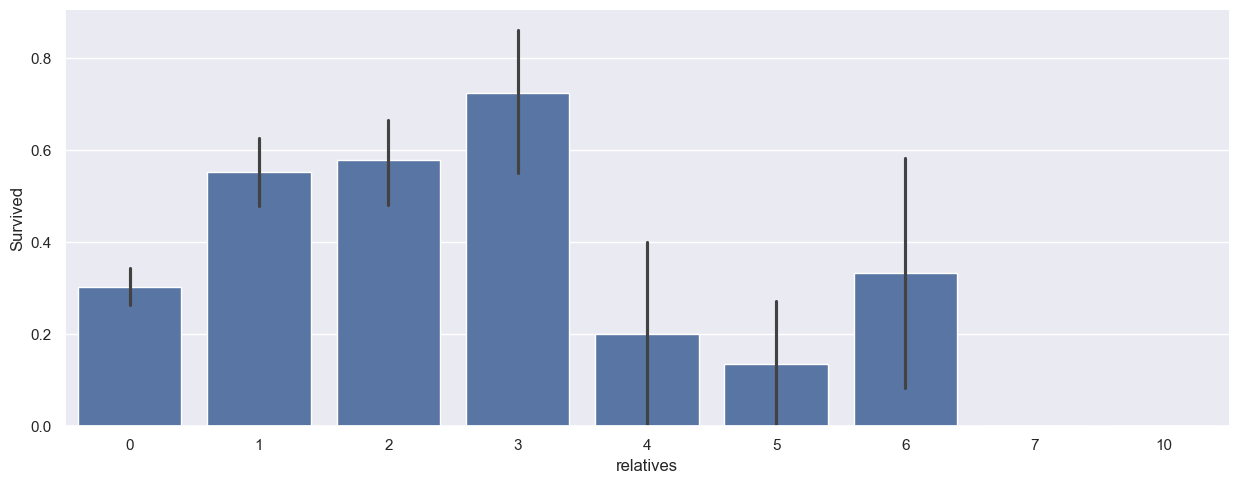

In [20]:
import seaborn as sns

data = [train_data, test_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'travelled_alone'] = 'No'
    dataset.loc[dataset['relatives'] == 0, 'travelled_alone'] = 'Yes'

# Use catplot with kind='bar'
axes = sns.catplot(x='relatives', y='Survived', data=train_data, aspect=2.5, kind='bar')


In [21]:
df = pd.read_csv("train.csv")
fig = px.histogram(df, x="SibSp", y="Parch", color="Sex", marginal="rug",
                   hover_data=df.columns)
fig.show()

In [22]:
for template in ["plotly_dark"]:
    fig = px.scatter(df,
                     x="PassengerId", y="Survived", color="Survived",
                     log_x=True, size_max=20,
                     template=template, title="Survived or Died?")
    fig.show()

In [23]:
from sklearn.ensemble import RandomForestClassifier

#data["Age"] = data["Age"].astype(int)
#if ["Age"]

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=2)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)